# Build Tech Tree Representation

In [1]:
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
import pickle

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

import ohol_transitions as trans
import ohol_categories as cat
import ohol_objects as obj

obj: id-name dictionary

In [2]:
gsearch = lambda *args: glob.glob(opj(*args))
obj_dir = opj('../../OneLifeData7/', 'objects')
obj_files = gsearch(obj_dir, '*txt')

In [3]:
str_extract = lambda pattern, s: re.search(pattern, s).group(0)
int_extract = lambda pattern, s: int(str_extract(pattern, s))
all_obj = {}
for o in obj_files:
    is_obj = re.search('nextObjectNumber|groundHeat', o) is None
    
    if is_obj:
        o_num = int_extract('[0-9]+(?=.txt)', o)
        o_data = obj.read_obj(o_num)
        all_obj[o_num] = o_data['name']
all_obj[0] = 'empty hand'
all_obj[4348] = 'empty ground'

## open previously saved data from 3_3_build_tree

In [4]:
with open('tech_outputs/adj.p', 'rb') as fp:
    data = pickle.load(fp)

In [5]:
with open('tech_outputs/ingredients.p', 'rb') as fp:
    unique_items = pickle.load(fp)

In [6]:
df = pd.DataFrame.from_dict(data, orient = 'index', columns = {'ingredient1', 'ingredient2'})
df['product'] = df.index

In [7]:
adj_df = df.sort_values(by = 'product').reset_index(drop = True)
adj_df.head()

,ingredient1,ingredient2,product
0,30,0,31
1,32,33,34
2,31,135,35
3,34,36,39
4,39,0,40


In [8]:
for i in range(len(adj_df)):
    sub = adj_df.iloc[i]
    if sub['ingredient1'] ==0:
        sub['ingredient1'] = sub['ingredient2']
        sub['ingredient2'] = 0

## helper functions

In [9]:
def build_branches(item_id):
    all_items = np.append(item_id, unique_items[item_id])
    level = {}
    level[0] = 0
    level[4348] = 0
    level[4349] = 0
    item_df = pd.DataFrame(columns = ['id','parent'])

    remaining_items = all_items
    while len(remaining_items):
        current_idx = np.argmin([len(unique_items[i]) for i in remaining_items])
        current_item = remaining_items[current_idx]

        if current_item in adj_df['product'].tolist():
            formula = adj_df.query('product == @current_item')
            ingredient1 = formula['ingredient1'].values[0]
            ingredient2 = formula['ingredient2'].values[0]
            level[current_item] = max(level[ingredient1], level[ingredient2]) +1
            item_df = item_df.append({'id':ingredient1, 'parent':current_item}, ignore_index=True)
            item_df = item_df.append({'id':ingredient2, 'parent':current_item}, ignore_index=True)
        else:
            level[current_item] = 0

        remaining_items = np.delete(remaining_items, current_idx)
        
    return item_df

In [10]:
def find_parents(mydict, child):
    parents = []
    for i in mydict:
        if mydict[i] == child:
            i = [i,i]
            parents = np.append(parents, i)
    parents = [int(i) for i in parents]                            
    
    return parents

In [11]:
def name(item):
    return all_obj[item]

find an item

In [12]:
myitem = 248

build a child-parent dataframe (each row is an edge)

In [13]:
item_df = build_branches(myitem)
item_df =item_df.replace({4349:-2, 4348:-1})
all_nodes = item_df['id'].tolist()
r = len(all_nodes)
r

48

In [14]:
item_df.head()

,id,parent
0,153,132
1,0,132
2,63,48
3,0,48
4,50,57


To allow for repeated nodes, we give each node a unique new name

In [52]:
mapping = {}
for i in range(r):
    mapping[5000+i] = all_nodes[i]
mapping[myitem] = myitem

In [53]:
mapping

{248: 248,
 5000: 153,
 5001: 0,
 5002: 63,
 5003: 0,
 5004: 50,
 5005: 0,
 5006: 49,
 5007: 0,
 5008: 63,
 5009: 0,
 5010: 65,
 5011: 0,
 5012: 32,
 5013: 33,
 5014: 57,
 5015: 57,
 5016: 48,
 5017: 0,
 5018: 58,
 5019: 58,
 5020: 64,
 5021: 34,
 5022: 66,
 5023: 34,
 5024: 34,
 5025: 67,
 5026: 59,
 5027: 68,
 5028: 69,
 5029: 59,
 5030: 70,
 5031: 34,
 5032: 71,
 5033: 132,
 5034: 73,
 5035: 69,
 5036: 74,
 5037: 67,
 5038: 75,
 5039: 62,
 5040: 77,
 5041: 61,
 5042: 78,
 5043: -1,
 5044: 80,
 5045: 72,
 5046: 82,
 5047: 67}

In [54]:
len(mapping)

49

build another dictionary that maps back

In [18]:
reverse_mapping={}
for i in all_nodes:
    parents = find_parents(mapping, i)
    reverse_mapping[i] = parents

In [19]:
reverse_mapping

{-1: [5043, 5043],
 0: [5001,
  5001,
  5003,
  5003,
  5005,
  5005,
  5007,
  5007,
  5009,
  5009,
  5011,
  5011,
  5017,
  5017],
 32: [5012, 5012],
 33: [5013, 5013],
 34: [5021, 5021, 5023, 5023, 5024, 5024, 5031, 5031],
 48: [5016, 5016],
 49: [5006, 5006],
 50: [5004, 5004],
 57: [5014, 5014, 5015, 5015],
 58: [5018, 5018, 5019, 5019],
 59: [5026, 5026, 5029, 5029],
 61: [5041, 5041],
 62: [5039, 5039],
 63: [5002, 5002, 5008, 5008],
 64: [5020, 5020],
 65: [5010, 5010],
 66: [5022, 5022],
 67: [5025, 5025, 5037, 5037, 5047, 5047],
 68: [5027, 5027],
 69: [5028, 5028, 5035, 5035],
 70: [5030, 5030],
 71: [5032, 5032],
 72: [5045, 5045],
 73: [5034, 5034],
 74: [5036, 5036],
 75: [5038, 5038],
 77: [5040, 5040],
 78: [5042, 5042],
 80: [5044, 5044],
 82: [5046, 5046],
 132: [5033, 5033],
 153: [5000, 5000]}

generate a new dataframe based on new node names

In [21]:
item_newdf = pd.DataFrame(columns = ['id','parent'])
# item_newdf['id'] = 5000+item_newdf.index
for i in range(len(item_df)):
    old_parent = item_df.iloc[i]['parent']
    if old_parent != myitem:
        new_parent = reverse_mapping[old_parent][0]##take the first parent and drop it from dict
        reverse_mapping[old_parent] = reverse_mapping[old_parent][1:]
        item_newdf = item_newdf.append({'id':5000+i,'parent':new_parent},ignore_index=True)
    else:
        item_newdf = item_newdf.append({'id':5000+i,'parent':old_parent},ignore_index=True)

        

## plot tech tree

How many unique ingredients are there in my item?

In [22]:
l = len(unique_items[myitem])
l

30

remove 0s

In [55]:
nodes0 = list(set(reverse_mapping[0]))
for i in nodes0:
    del mapping[i]

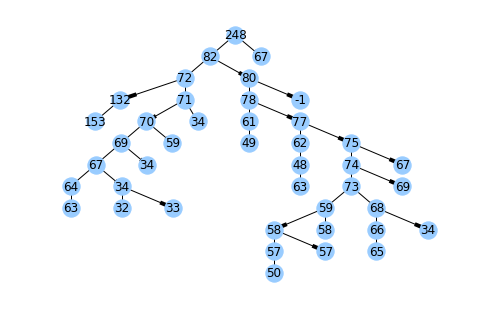

In [56]:
G = nx.from_pandas_edgelist(item_newdf, 'parent', 'id', None, nx.DiGraph()) 
G.remove_nodes_from(nodes0)#remove 0s
pos=graphviz_layout(G, prog='dot')
if l>100:
    ns = 100
    fs = 10
else:
    ns = 300
    fs = 12
nx.draw(G, pos, with_labels= True, labels=mapping, node_color='#99ccff', node_size=ns, font_size=fs)
plt.figure(figsize=(100,100)) 
plt.draw()
plt.show()

What's my item's name?

In [546]:
all_obj[myitem]

'Firebrand'

check the number of nodes in the graph

In [57]:
len(G)

42

check the number of edges in the graph

In [58]:
G.number_of_edges()

41

## Scratch

In [ ]:
def node_left(item_id):
    formula = adj_df.query('product == @item_id')
    if len(formula):
        ingredient1 = formula['ingredient1'].values[0]
    #     ingredient2 = formula['ingredient2'].values[0]
        G.add_node(item_id)
        G.add_node(ingredient1)
        G.add_edge(item_id, ingredient1, length=500)
    #     G.add_path([item_id, ingredient2])
        return ingredient1
    else:
        return 0

In [ ]:
def node_right(item_id):
    
    formula = adj_df.query('product == @item_id')
    if len(formula):
        ingredient2 = formula['ingredient2'].values[0]
    #     ingredient2 = formula['ingredient2'].values[0]
#         G.add_node(item_id)
#         G.add_node(ingredient2)
        G.add_edge(item_id, ingredient2, length=500)
    #     G.add_path([item_id, ingredient2])
        if ingredient2 == 0:
            ingredient2 = 1
        return ingredient2
    else:
        return 0
    
   

In [509]:
G = nx.DiGraph()
item_id = 248

In [510]:
#go down the left
level = 0
changed = 0
stop = 0
nodes_tot = []
ids = [0] * 100
times = 0
while not stop:
    if (item_id in adj_df['product'].tolist()) and ((not changed) or new_node):
        ids[level] = item_id
        item_id = node_left(item_id)
        level = level +1
        nodes_tot = np.append(nodes_tot, item_id)
        changed = 0
        print('item if%', item_id)
        print('level if%', level)
    else:
        level = level -1
        item_id = ids[level]
        if node_right(item_id):
            item_id = node_right(item_id)
            print('item else%', item_id)
            print('level else%', level)
            changed = 1
        if item_id not in nodes_tot:
            new_node = 1
        else:
            new_node = 0
        nodes_tot = np.append(nodes_tot, item_id)
    
    if level == 0: ##comming back to top
        times = times +1
        changed = 0
        stop = 0
        nodes_tot = []
        ids = [0] * 100
        item_id = adj_df.query('product == 248')['ingredient2'].values[0]
    if times == 2:
        stop =1
    


item if% 82
level if% 1
item if% 80
level if% 2
item if% 78
level if% 3
item if% 77
level if% 4
item if% 75
level if% 5
item if% 74
level if% 6
item if% 73
level if% 7
item if% 59
level if% 8
item if% 58
level if% 9
item if% 57
level if% 10
item if% 50
level if% 11
item else% 1
level else% 10
item else% 57
level else% 9
item else% 58
level else% 8
item else% 68
level else% 7
item if% 66
level if% 8
item if% 65
level if% 9
item else% 1
level else% 8
item else% 34
level else% 7
item if% 32
level if% 8
item else% 33
level else% 7
item else% 69
level else% 6
item if% 34
level if% 7
item if% 32
level if% 8
item else% 33
level else% 7
item else% 67
level else% 6
item if% 64
level if% 7
item if% 63
level if% 8
item else% 1
level else% 7
item else% 34
level else% 6
item else% 67
level else% 5
item else% 62
level else% 4
item if% 48
level if% 5
item if% 63
level if% 6
item else% 1
level else% 5
item else% 1
level else% 4
item else% 61
level else% 3
item if% 49
level if% 4
item else% 1
level els

In [511]:
adj_df.query('product == 248')['ingredient2'].values[0]

67

In [512]:
# nx.relabel_nodes(G, name, copy=False)
G.remove_node(0)
# G.remove_node(4348)

In [513]:
len(G)

32

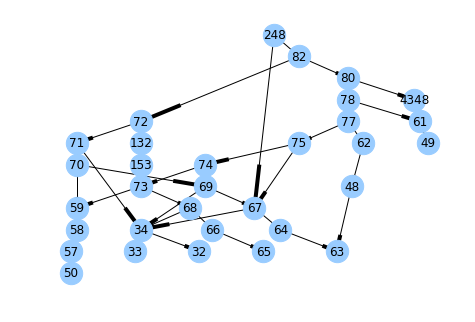

In [514]:
nx.nx_agraph.write_dot(G,'test.dot')
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels= True, node_color='#99ccff', node_size=500, arrows=True)
# plt.figure(figsize=(100,100)) 
plt.draw()
plt.show()

In [61]:
ids[0]

283